### Notebook for the pseudotime analysis of ACM myeloid using `cellrank2`

- **Developed by:** Alexandra Cirnu
- **Modified by:** Carlos Talavera-López
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 240514
- **Date of modification:** 240515

### Import required modules

In [1]:
import scipy
import anndata
import warnings
import palantir
import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import scvelo as scv
import plotnine as p
import seaborn as sns
import cellrank as cr
from muon import atac as ac
from muon import prot as pt
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

/Users/cartalop/mambaforge/envs/cellrank2/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/cartalop/mambaforge/envs/cellrank2/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/cartalop/mambaforge/envs/cellrank2/lib/python3.9/si

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.3
-----
PIL                 10.0.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cellrank            2.0.4
cloudpickle         2.2.1
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
docrep              0.3.2
etils               1.4.0
executing           1.2.0
fcsparser           0.2.8
h5py                3.9.0
igraph              0.11.5
importlib_resources NA
ipykernel           6.25.0
ipywidgets          8.0.7
jax                 0.4.13
jaxlib              0.4.13
jaxopt              NA
jedi                0.18.2
joblib              1.3.1
kiwisolver          1.4.4
leidenalg           0.10.2
llvmlite            0.40.1
matplotlib          3.7.1
mellon              1.4.2
mizani              0.11.3
ml_dtypes           0.2.0
mpl_toolkits        NA
mudata              0.2.3
muon                0.1.6
natsort             8

### Read in data

In [3]:
adata = sc.read_h5ad('../../data/ACM_myeloids_clustered_ct240515.raw.h5ad')     
adata

AnnData object with n_obs × n_vars = 31174 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'classification_colors', 'condition_colors', 'genotype_colors', 'infection_colors', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    obsp: 'connectivities', 'distances'

In [4]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))
X_is_raw(adata)

True

In [5]:
adata.obs['C_scANVI'].value_counts()

LYVE1+MØ      12664
MØ_general     9842
DOCK4+MØ       4540
Monocytes      4128
Name: C_scANVI, dtype: int64

### Compute diffusion map

In [6]:
sc.tl.diffmap(adata, 
              n_comps = 150, 
              random_state = 1786)

computing Diffusion Maps using n_comps=150(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.97862685 0.97118235 0.95801914 0.9546901  0.9484767
     0.94356304 0.93425256 0.93164563 0.92446613 0.9182562  0.91261023
     0.9120488  0.900149   0.89681613 0.88959366 0.8854422  0.8842801
     0.8828548  0.8754777  0.873227   0.87085575 0.8633731  0.85140157
     0.8506614  0.84466356 0.8433441  0.8411138  0.83630484 0.8352291
     0.8331706  0.8321211  0.8281951  0.8242188  0.81910795 0.8163348
     0.81050414 0.8100444  0.80587065 0.8026125  0.80093086 0.7984573
     0.7962702  0.79221916 0.7906216  0.789313   0.7867618  0.78461957
     0.7808094  0.7803115  0.77577764 0.7723391  0.77065575 0.7695543
     0.76848656 0.76623976 0.7620585  0.75889504 0.75761265 0.7567412
     0.755568   0.7552162  0.7548678  0.75310427 0.75035256 0.74811006
     0.7469098  0.74555683 0.74417835 0.7437021  0.74111396 0.7397909
     0.73866534 0.73750

### Select root cell using extrema of diffusion components

In [7]:
adata.obsm['X_diffmap'][:, 3].argmax()

9898

/Users/cartalop/mambaforge/envs/cellrank2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


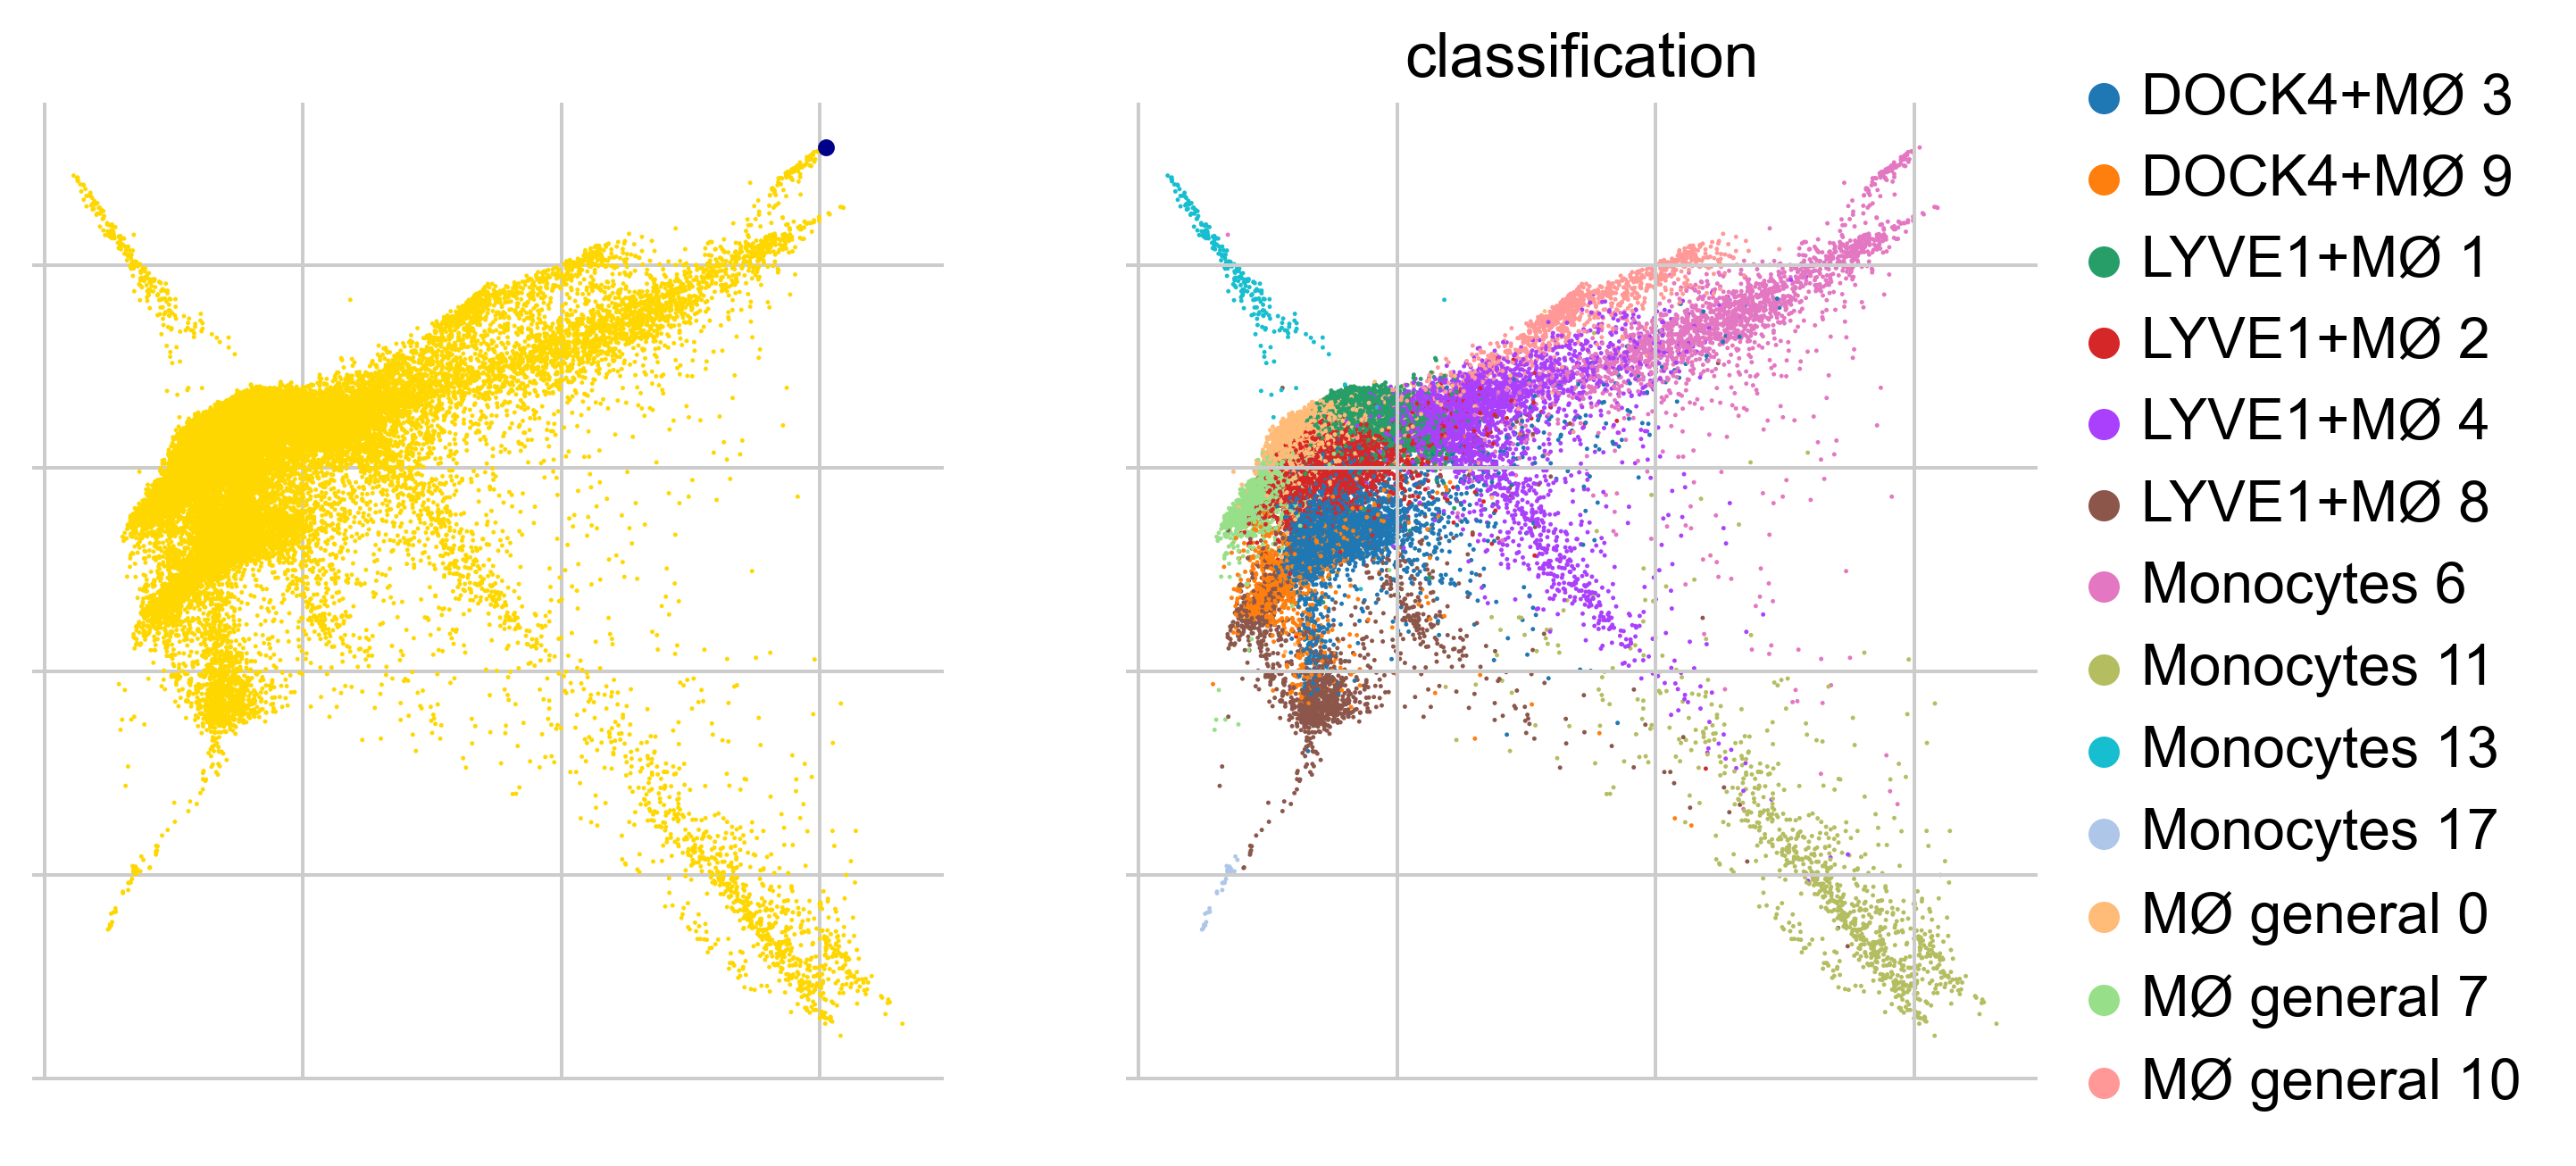

In [8]:
root_ixs = 9898 
scv.pl.scatter(
    adata,
    basis = "diffmap",
    c = [root_ixs, "classification"],
    legend_loc = "right",
    components = ["2, 3"],
)

adata.uns["iroot"] = root_ixs

In [9]:
sc.tl.dpt(adata, 
          n_dcs = 150)

computing Diffusion Pseudotime using n_dcs=150
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/Users/cartalop/mambaforge/envs/cellrank2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


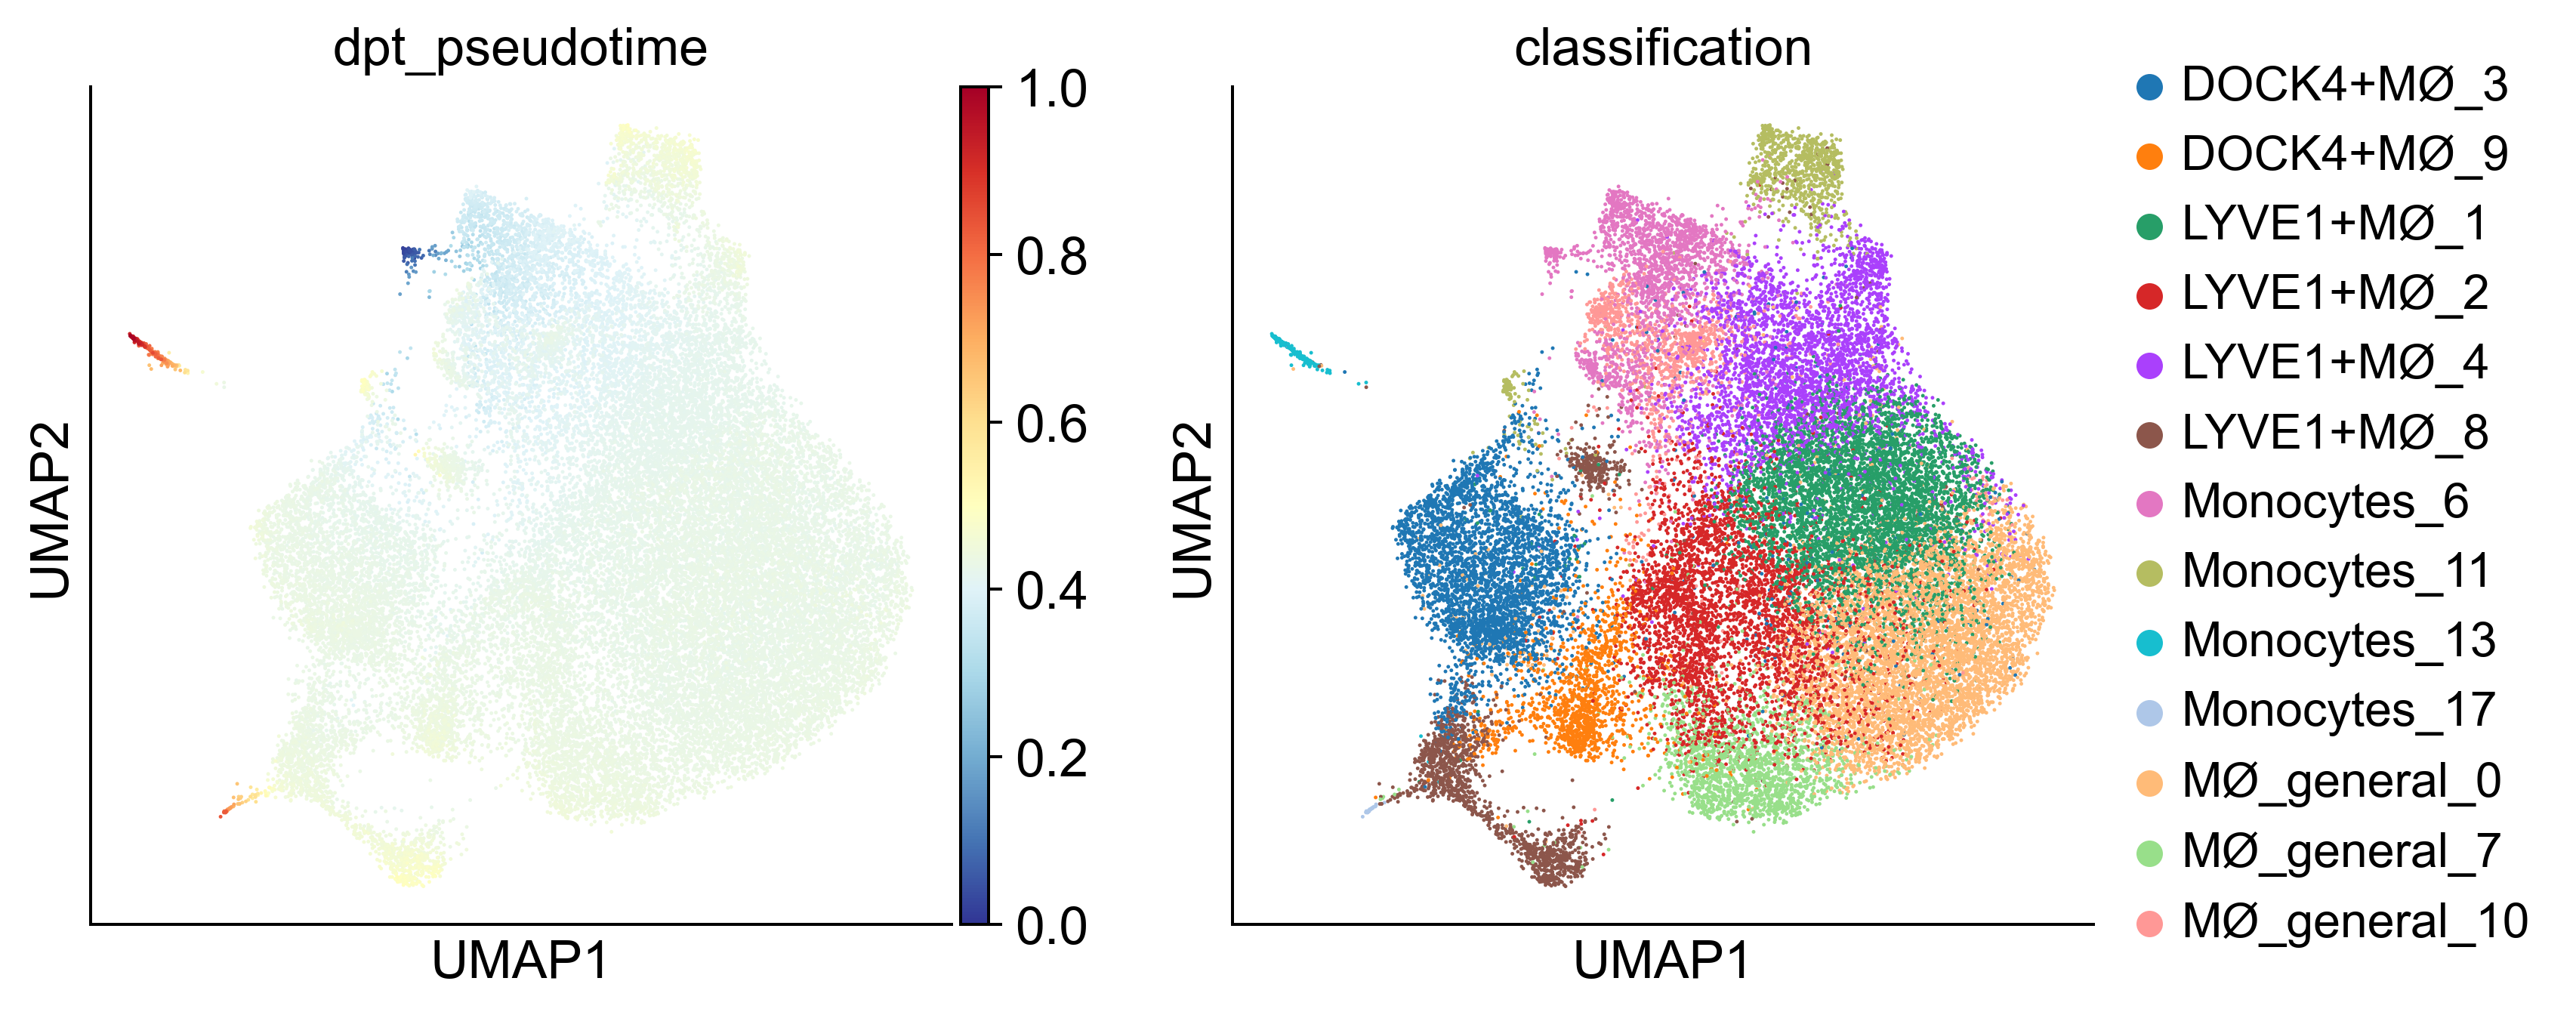

In [10]:
sc.pl.embedding(
    adata,
    basis = "umap",
    color = ["dpt_pseudotime", "classification"],
    color_map = "RdYlBu_r",
)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [11]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

NameError: name 'scvi_model' is not defined

In [ ]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

In [ ]:
adata_raw = ad.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)          
adata_raw     

### Diffusion maps

In [ ]:
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5, pca_key= "X_scVI")

In [ ]:
ms_data = palantir.utils.determine_multiscale_space(adata)

In [ ]:
adata

### Visualization

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 150, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 1.5, spread = 10, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['classification'], size = 4)

### MAGIC imputation

In [ ]:
imputed_X = palantir.utils.run_magic_imputation(adata)

In [ ]:
hvg_list = adata.var[adata.var['highly_variable']].index.tolist()
print(hvg_list)

In [ ]:
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["Ly6c1", "Cd209a", "Ccr2", "Trem2", "Timd4", "Il1b"],
    frameon=False,
)
plt.show()

### Diffusion maps visualization

In [ ]:
palantir.plot.plot_diffusion_components(adata)
plt.show()

### Running Palantir

Find an appropriate start cell - Ly6C high monocyte

In [ ]:
if 'Ly6c1' in adata.var_names:
    ly6c1_expression = adata[:, 'Ly6c1'].X

    # Check if data is stored as sparse matrix and convert to dense if necessary
    if isinstance(ly6c1_expression, scipy.sparse.spmatrix):
        ly6c1_expression = ly6c1_expression.toarray()
    # Flatten the array to 1D if necessary
    ly6c1_expression = ly6c1_expression.flatten()
    # Find the index of the maximum expression
    max_expression_index = ly6c1_expression.argmax()
    # Retrieve the cell ID using the index
    cell_id_with_max_ly6c1 = adata.obs_names[max_expression_index]

    print(f"Cell with highest Ly6c1 expression is {cell_id_with_max_ly6c1} at index {max_expression_index}.")
else:
    print("Ly6c1 is not a valid gene name in this dataset.")

start_cell = cell_id_with_max_ly6c1 
start_cell

Define terminally differentiated monocyte by Ly6c expression

In [ ]:
if 'Timd4' in adata.var_names:
    ly6c1_expression = adata[:, 'Timd4'].X

    # Check if data is stored as sparse matrix and convert to dense if necessary
    if isinstance(ly6c1_expression, scipy.sparse.spmatrix):
        ly6c1_expression = ly6c1_expression.toarray()
    # Flatten the array to 1D if necessary
    ly6c1_expression = ly6c1_expression.flatten()
    # Find the index of the maximum expression
    max_expression_index = ly6c1_expression.argmax()
    # Retrieve the cell ID using the index
    cell_id_with_max_ly6c1 = adata.obs_names[max_expression_index]

    print(f"Cell with highest Timd4 expression is {cell_id_with_max_ly6c1} at index {max_expression_index}.")
else:
    print("Timd4 is not a valid gene name in this dataset.")

In [ ]:
if 'Ccr2' in adata.var_names:
    ly6c1_expression = adata[:, 'Ccr2'].X

    # Check if data is stored as sparse matrix and convert to dense if necessary
    if isinstance(ly6c1_expression, scipy.sparse.spmatrix):
        ly6c1_expression = ly6c1_expression.toarray()
    # Flatten the array to 1D if necessary
    ly6c1_expression = ly6c1_expression.flatten()
    # Find the index of the maximum expression
    max_expression_index = ly6c1_expression.argmax()
    # Retrieve the cell ID using the index
    cell_id_with_max_ly6c1 = adata.obs_names[max_expression_index]

    print(f"Cell with highest Ccr2 expression is {cell_id_with_max_ly6c1} at index {max_expression_index}.")
else:
    print("Ccr2 is not a valid gene name in this dataset.")

In [ ]:
if 'Trem2' in adata.var_names:
    ly6c1_expression = adata[:, 'Trem2'].X

    # Check if data is stored as sparse matrix and convert to dense if necessary
    if isinstance(ly6c1_expression, scipy.sparse.spmatrix):
        ly6c1_expression = ly6c1_expression.toarray()
    # Flatten the array to 1D if necessary
    ly6c1_expression = ly6c1_expression.flatten()
    # Find the index of the maximum expression
    max_expression_index = ly6c1_expression.argmax()
    # Retrieve the cell ID using the index
    cell_id_with_max_ly6c1 = adata.obs_names[max_expression_index]

    print(f"Cell with highest Trem2 expression is {cell_id_with_max_ly6c1} at index {max_expression_index}.")
else:
    print("Trem2 is not a valid gene name in this dataset.")

In [ ]:
terminal_states = pd.Series(
    ["Tissue_resident", "pro_inflam", "tissue_injury"],
    index=["GAGGCCTCAAACCATC-1-A4", "TCGCTCACAAGCACCC-1-A1", "TCCGTGTCATTGAAGA-1-A1"]
)

In [ ]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states)
plt.show()

Palantir generates the following results

- Pseudotime: Pseudo time ordering of each cell
- Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
- Entropy: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities

In [ ]:
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states)

### Visualizing Palantir results

In [ ]:
palantir.plot.plot_palantir_results(adata, s=3)
plt.show()

In [ ]:
adata.obs_names

In [ ]:
cells = ['TTCTCTCTCTGCGAGC-1-A3', 'TTTCACACACATATCG-1-B2'] 

palantir.plot.plot_terminal_state_probs(adata, cells)
fig = plt.gcf()
ax = fig.axes[1]
ax.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.axes[0]
ax.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
palantir.plot.highlight_cells_on_umap(adata, cells)
plt.show()

### Gene Expression Trends

Selecting cells of a specific trend

In [ ]:
masks = palantir.presults.select_branch_cells(adata, eps=0)

Visualizing the branch selection

In [ ]:
palantir.plot.plot_branch_selection(adata)
plt.show()

In [ ]:
palantir.plot.plot_trajectory(adata, "ACTGATGCATGTGGTT-1-B2")

In [ ]:
palantir.plot.plot_trajectory(
    adata,
    "ACTGATGCATGTGGTT-1-B2",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

### Compute a transition matrix with cellrank

In [ ]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

print(pk)

In [ ]:
pk.plot_projection(basis="umap", recompute=True)

In [ ]:
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)

In [ ]:
genes = ["Ly6c1", "Cd209a", "Gng11", "Ccl6", "Ms4a4c"]
palantir.plot.plot_gene_trends(adata, genes)
plt.show()

### Modify object to plot canonical marker genes

In [ ]:
adata

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI', 'Cd79a', 'Nkg7', 'Klrb1', 'Ccr7', 'Itga1', 'Cx3cr1', 'Gzmk', 'Klrg1'], size = 5, legend_fontsize = 5, ncols = 3, cmap = 'RdPu')

#Cd79a, Ms4a1, Cd19                                             //B cells
#Nkg7, Gnly, Cd8a                                               //NKT
#Gnly, Xcl2, Nkg7                                               //NK
#Klrb1, Aqp3, Itgb1, Ccr7, Sell, Cd4                            //CD4 T cells
#Itga1, Itgae, Cxcr6, Cx3cr1, Gzmb, Gnly, Gzmk, Cd8a, Ccl5      //C8 T cells
#Klrg1                                                          //MCMV-spec T cells

### Compute `scib-metrics`

In [ ]:
adata

In [ ]:
adata.obs["seed_labels"].value_counts()

In [ ]:
adata.X = adata.X.astype(float)

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="donor",
    label_key="seed_labels",                                       #take C_scANVI oder seed_labels containing 'Unknown'??
    embedding_obsm_keys=["X_scVI", "X_scANVI", "X_pca"],
    n_jobs=3,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
df.transpose()

In [ ]:
adata.X = adata.X.astype(int)

In [ ]:
X_is_raw(adata)

### Visualise proportions

In [ ]:
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, title=cat, **kwargs)
    plt.tight_layout()

In [ ]:
from pylab import *

cmap = cm.get_cmap('tab20', 20)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

cmap = cm.get_cmap('plasma', 101)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
print(color_list)

In [ ]:
adata.obs["C_scANVI"].cat.categories

In [ ]:
sc.pl.umap(adata, 
           frameon = False, 
           color = ['C_scANVI'], 
           size = 5, 
           legend_fontsize = 6, 
           ncols = 1, 
           palette = {
                'B':                    '#FF7F0E',  # Orange
                'CD4':                  '#945943',  # Brown
                'CD8':                  '#F9D090',  # Beige-Yellow
                'NK':                   '#C70039',  # Crimson-Red
                'NKT':                  '#B58A58',  # Teak (brown)
           })


In [ ]:
split_umap(adata, color = ['C_scANVI'], split_by = 'infection', frameon = False, size = 12, legend_fontsize = 5, ncols = 4,            
           palette = {
                'B':                    '#FF7F0E',  # Orange
                'CD4':                  '#945943',  # Brown
                'CD8':                  '#F9D090',  # Beige-Yellow
                'NK':                   '#C70039',  # Crimson-Red
                'NKT':                  '#B58A58',  # Teak (brown)
           })

In [ ]:
split_umap(adata, color = ['C_scANVI'], split_by = 'condition', frameon = False, size = 20, legend_fontsize = 5, ncols = 4, palette = {
                'B':                    '#FF7F0E',  # Orange
                'CD4':                  '#945943',  # Brown
                'CD8':                  '#F9D090',  # Beige-Yellow
                'NK':                   '#C70039',  # Crimson-Red
                'NKT':                  '#B58A58',  # Teak (brown)
           })

In [ ]:
split_umap(adata, color = ['C_scANVI'], split_by = 'genotype', frameon = False, size = 17, legend_fontsize = 5, ncols = 4, palette = {
                'B':                    '#FF7F0E',  # Orange
                'CD4':                  '#945943',  # Brown
                'CD8':                  '#F9D090',  # Beige-Yellow
                'NK':                   '#C70039',  # Crimson-Red
                'NKT':                  '#B58A58',  # Teak (brown)
           })

In [ ]:
split_umap(adata, color = ['C_scANVI'], split_by = 'model', frameon = False, size = 10, legend_fontsize = 5, ncols = 4, palette = {
                'B':                    '#FF7F0E',  # Orange
                'CD4':                  '#945943',  # Brown
                'CD8':                  '#F9D090',  # Beige-Yellow
                'NK':                   '#C70039',  # Crimson-Red
                'NKT':                  '#B58A58',  # Teak (brown)
           })

In [ ]:
df = adata_toplot.obs.groupby(['condition', 'C_scANVI']).size().reset_index(name = 'counts')

grouped = df.groupby('condition')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
from matplotlib.colors import ListedColormap
cmap_ac = ListedColormap(['#FF7F0E', '#945943', '#F9D090', '#C70039', '#B58A58']) 
cmap_ac

In [ ]:
tab20_palette = cmap_ac 


for group in df['condition'].unique():
    temp_df = df[df['condition'] == group]
    
    data = dict(zip(temp_df['C_scANVI'], temp_df['waffle_counts']))
    colors = [tab20_palette(i) for i in range(len(temp_df['C_scANVI']))]
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 10, 
        values = data, 
        title = {'label': f'Condition {group}', 'loc': 'left', 'fontsize': 14},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df['C_scANVI'], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'upper left', 'bbox_to_anchor': (0, 0), 'ncol': 8, 'framealpha': 0, 'fontsize': 14},
        figsize = (40, 4),
        colors = colors
    )
    plt.show()

In [ ]:
pd.crosstab(adata.obs['C_scANVI'], adata.obs['condition'])

### Visualize n_genes by condition to be able to set a threshold for trimming out low-gene-clusters

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
sns.set(style="whitegrid")
covariate_to_visualize = 'n_genes_by_counts'

plt.figure(figsize=(10, 6))
sns.histplot(data=adata.obs, x=covariate_to_visualize, hue='C_scANVI', stat='count', common_norm=False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Condition')
plt.legend(['B', 'CD4', 'CD8', 'NK', 'NKT'], title='Cell_Type', loc='upper right')

plt.show()

In [ ]:
sns.set(style="whitegrid")
covariate_to_visualize = 'n_genes_by_counts'

sample_names = adata.obs['condition'].unique()
num_samples = len(sample_names)
color_palette = sns.color_palette("Set1", n_colors=num_samples)

g = sns.FacetGrid(adata.obs, col="C_scANVI", col_wrap=3, height=5, palette=color_palette)
g.map_dataframe(sns.histplot, x=covariate_to_visualize, stat='count', common_norm=False)

g.set_axis_labels(covariate_to_visualize, 'Abundance')
g.set_titles(col_template="{col_name}")
#g.add_legend(['B_cells', 'CD4+T', 'CD8+T', 'DC', 'Hematopoetic', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK', 'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'], title='Cell_Type', loc='upper right')

plt.tight_layout()
plt.show()

Set threshold at 500 genes?

### Export annotated sample object 

In [ ]:
adata.obs.index

In [ ]:
prot = mdata.mod['prot']
prot.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export

#### Update the mdata object

In [ ]:
mdata.mod['rna'] = adata_export
mdata

In [ ]:
mdata.mod['rna'].obs_names

In [ ]:
mdata.mod['prot'].obs_names

In [ ]:
rna_cells_export = set(mdata.mod['rna'].obs_names)
mask = mdata.mod['prot'].obs_names.isin(rna_cells_export)
filtered_prot_export = mdata.mod['prot'][mask]
mdata = mu.MuData({"rna": mdata.mod['rna'], "prot": filtered_prot_export})
mdata

In [ ]:
mdata.write('/home/acirnu/data/ACM_cardiac_leuco/4_Seed_labeling_with_scANVI/ACM_lymphoids_scANVI_general_celltypes_from_HCA_lymphoids_muon_ac240506.raw.h5mu')

#### Create stacked barplots in addition to waffle plots

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [ ]:
mdata = mu.read_h5mu('/home/acirnu/data/ACM_cardiac_leuco/4_Seed_labeling_with_scANVI/ACM_lymphoids_scANVI_general_celltypes_from_HCA_lymphoids_muon_ac240506.raw.h5mu')     

In [ ]:
adata = mdata.mod['rna']
adata

In [ ]:
df = adata.obs.groupby(['condition', 'C_scANVI']).size().reset_index(name = 'counts')

grouped = df.groupby('condition')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df.head(10)

In [ ]:
Pkp2_conditions = ["Pkp2_Ctr_noninf", "Pkp2_HetKO_noninf","Pkp2_Ctr_MCMV", "Pkp2_HetKO_MCMV"]
df_Pkp2 = df[df['condition'].isin(Pkp2_conditions)]
df_Pkp2 = df_Pkp2.set_index('condition').loc[Pkp2_conditions].reset_index()

In [ ]:
#Define a color map
cmap_ac = ['#FF7F0E', '#945943', '#F9D090', '#C70039', '#B58A58']  

# Pivot the DataFrame to have 'leiden' clusters as columns
pivot_df = df_Pkp2.pivot(index='condition', columns='C_scANVI', values='proportions').fillna(0)

# Plot the stacked barplot
plt.figure()  # Create a new figure
ax = pivot_df.plot(kind='bar', stacked=True, color=cmap_ac, edgecolor='none')

# Set the figure size explicitly after creating the figure
plt.gcf().set_size_inches(7, 7)

# Remove the grid
ax.grid(False)

# Add labels and title
plt.xlabel('')
plt.ylabel('Proportion (%)')
plt.title('')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig('stacked_barplot_Pkp2.png', dpi=300)
plt.show()


In [ ]:
Ttn_conditions = ["Ttn_Ctr_noninf", "Ttn_HetKO_noninf","Ttn_Ctr_MCMV", "Ttn_HetKO_MCMV"]
df_Ttn = df[df['condition'].isin(Ttn_conditions)]
df_Ttn = df_Ttn.set_index('condition').loc[Ttn_conditions].reset_index()

In [ ]:
#Define a color map
cmap_ac = ['#FF7F0E', '#945943', '#F9D090', '#C70039', '#B58A58']  

# Pivot the DataFrame to have 'leiden' clusters as columns
pivot_df = df_Ttn.pivot(index='condition', columns='C_scANVI', values='proportions').fillna(0)

# Plot the stacked barplot
plt.figure()  # Create a new figure
ax = pivot_df.plot(kind='bar', stacked=True, color=cmap_ac, edgecolor='none')

# Set the figure size explicitly after creating the figure
plt.gcf().set_size_inches(7, 7)

# Remove the grid
ax.grid(False)

# Add labels and title
plt.xlabel('')
plt.ylabel('Proportion (%)')
plt.title('')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig('stacked_barplot_Ttn.png', dpi=300)
plt.show()